In [1]:
!pip install pyvi
!pip install pydot
!pip install pydot_ng
!pip install graphviz


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
%matplotlib inline

In [3]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [4]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


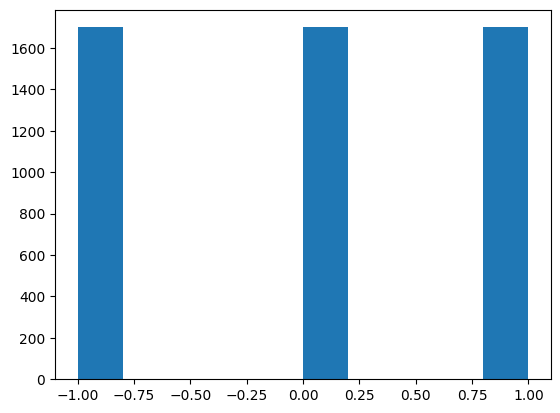

In [5]:
import matplotlib.pyplot as plt

plt.hist(data_train["Class"])
plt.show()

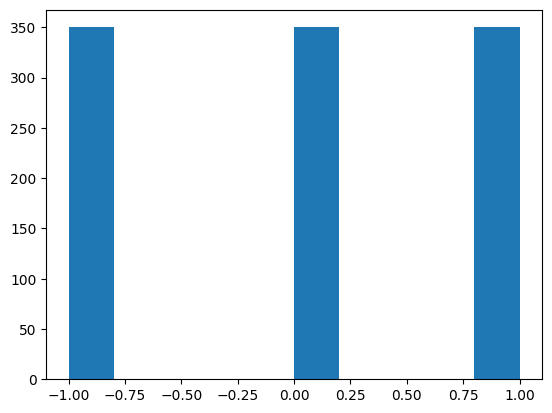

In [6]:
plt.hist(data_test["Class"])
plt.show()

In [7]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [8]:
encoded_labels = []

for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)  

In [9]:
reviews_processed = []
unlabeled_processed = [] 
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)

In [10]:
#Use PyVi for Vietnamese word tokenizer
word_reviews = []
all_words = []
for review in reviews_processed:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())

In [11]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [13]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [14]:
print('Shape of X train and X validation tensor:',data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (5100, 300)
Shape of label train and validation tensor: (5100, 3)


In [15]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)


vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [16]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPool1D(300)(conv_0)
conv_1 = MaxPool1D(300)(conv_1)
conv_2 = MaxPool1D(300)(conv_2)

conv = concatenate([conv_0, conv_1, conv_2])
conv = Flatten()(conv)

lstm_2 = LSTM(1024, return_sequences=True)(reshape)
lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
lstm_0 = LSTM(256, return_sequences=True)(lstm_1)

lstm_0 = Flatten()(lstm_0)

############################################################
cnn_lstm = concatenate([conv, lstm_0])
dropout = Dropout(drop)(cnn_lstm)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 400)     3167600     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 300, 400)     0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 300, 100)     120100      ['reshape[0][0]']                
                                                                                              

c:\Users\Quynh Huong\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


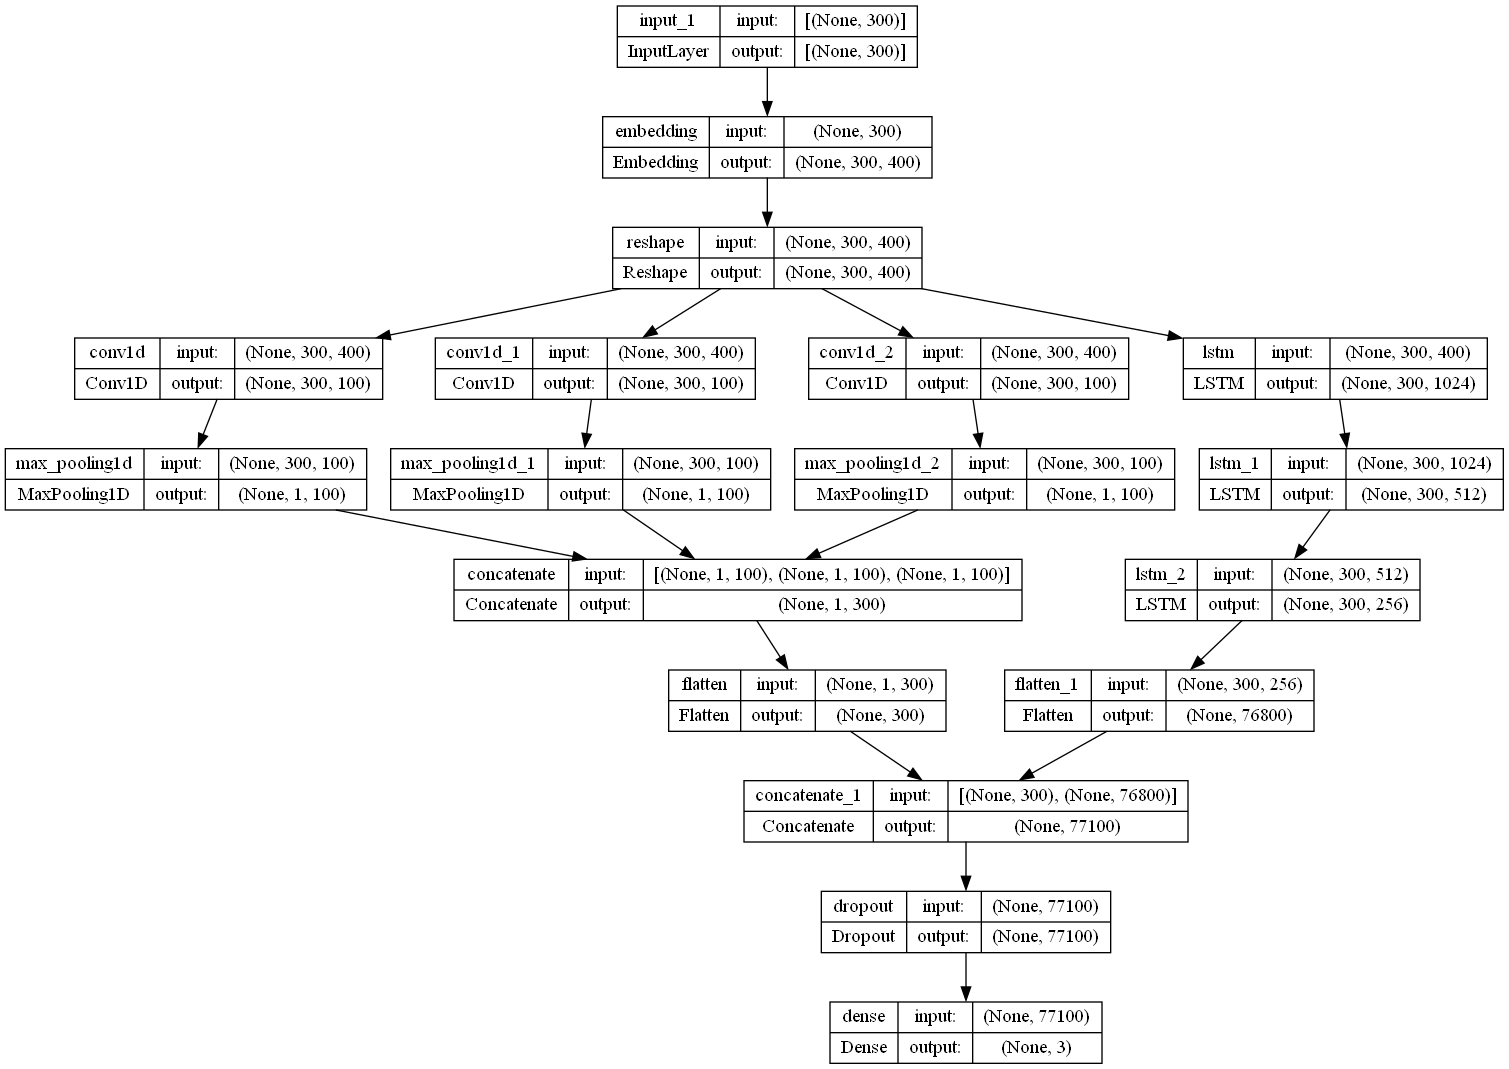

In [17]:
tf.keras.utils.plot_model(model, to_file="./visualize_CNN_and_LSTM_model.png", show_shapes=True)

In [18]:
model_history = model.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/10
16/16 [==============================] - 652s 42s/step - loss: 4.6906 - accuracy: 0.4534 - val_loss: 4.2045 - val_accuracy: 0.0049
Epoch 2/10
16/16 [==============================] - 863s 56s/step - loss: 2.5100 - accuracy: 0.5983 - val_loss: 2.8700 - val_accuracy: 0.0000e+00
Epoch 3/10
16/16 [==============================] - 1167s 75s/step - loss: 1.4365 - accuracy: 0.6703 - val_loss: 1.6970 - val_accuracy: 0.2510
Epoch 4/10
16/16 [==============================] - 1393s 89s/step - loss: 0.9462 - accuracy: 0.7419 - val_loss: 1.8397 - val_accuracy: 0.2294
Epoch 5/10
16/16 [==============================] - 1501s 94s/step - loss: 0.6954 - accuracy: 0.7926 - val_loss: 1.9587 - val_accuracy: 0.2814
Epoch 6/10
16/16 [==============================] - 1692s 107s/step - loss: 0.5375 - accuracy: 0.8350 - val_loss: 2.9786 - val_accuracy: 0.1422
Epoch 7/10
16/16 [==============================] - 1725s 108s/step - loss: 0.3949 - accuracy: 0.8890 - val_loss: 3.9031 - val_accuracy: 0.

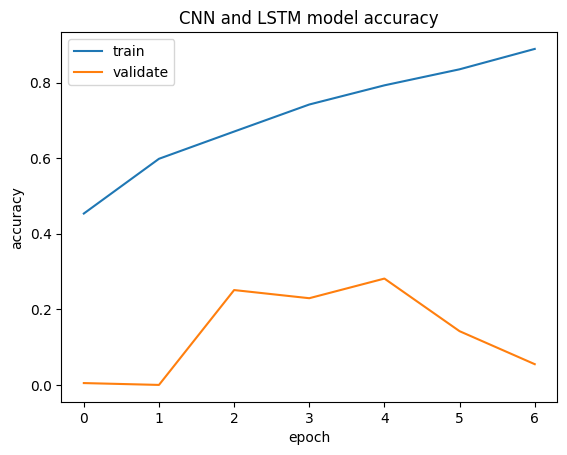

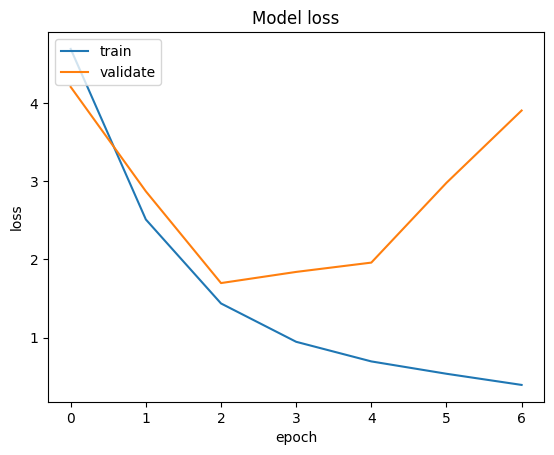

In [19]:
import matplotlib.pyplot as plt 

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

plt.title('CNN and LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [20]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [21]:
encoded_labels_test = []

for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test == 0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)  

In [22]:
reviews_processed_test = []
unlabeled_processed_test = [] 
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [23]:
#Use PyVi for Vietnamese word tokenizer
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [24]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [25]:
print('Shape of X test and X validation tensor:',data_test.shape)
print('Shape of label test and validation tensor:', labels_test.shape)

Shape of X test and X validation tensor: (1050, 300)
Shape of label test and validation tensor: (1050, 3)


In [26]:
score = model.evaluate(data_test, labels_test)

33/33 [==============================] - 111s 3s/step - loss: 1.3699 - accuracy: 0.6067


In [27]:
print("%s: %.2f" % (model.metrics_names[0], score[0]))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

loss: 1.37
accuracy: 60.67%
